In [1]:
import numpy as np
import torch
from financial_models.asset_price_models import GBM
from financial_models.option_price_models import BSM
from machin.frame.algorithms import DQN
from torch import nn
import gym
import time
from gym_hedging.environment import HedgingEnv 

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

seed = 345
np.random.seed(seed)
torch.manual_seed(seed)

tim = time.time()

mu = 0
dt = 1/128
T = 1
num_steps = T/dt
s_0 = 1
strike_price = s_0
sigma = 0.15
r = 0.01

apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)
env = HedgingEnv(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, trading_cost_para=1,
                     L=1, strike_price=strike_price, int_holdings=False, initial_holding=0, mode="PL",
               option_price_model=opm)

num_actions = 21

class QNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_num):
        super(QNet, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_num)

    def forward(self, state):
        a = torch.relu(self.fc1(state))
        a = torch.relu(self.fc2(a))
        return self.fc3(a)

qnet = QNet(4, 20, num_actions)
qnet_t = QNet(4, 20, num_actions)

dqn = DQN(qnet, qnet_t,
          torch.optim.Adam,
          nn.MSELoss(reduction='sum'), discount=0.8, epsilon_decay=0.999, learning_rate=0.001,
          lr_scheduler=torch.optim.lr_scheduler.StepLR, lr_scheduler_kwargs=[{"step_size": 1000*128}])

num_eps = 5000
norm_factor = 10000000

In [2]:
def run_comparison(dqn, env, num_runs=100):
    rows = {
        'rl':    [],
        'delta': []
    }
        
    for mode in rows.keys():
        for run in range(num_runs):
            np.random.seed(run)
            done  = False
            state = env.reset()
            state = state[[0, 1, 2, 4]]

            hedging_pnls = []
            trading_pnls = []
            rewards      = []

            while not done:
                if mode == 'delta':
                    action = state[3] - env.h
                    new_state, pnls, done = env.step(action)
                elif mode == 'rl':
                    out = dqn.act_discrete({"state": torch.tensor(state, dtype=torch.float32).unsqueeze(0)})
                    action = out.squeeze().detach().numpy() / num_actions
                    new_state, pnls, done = env.step(action - env.h)
                else:
                    assert False
                    
                reward                = (0.001*np.sum(pnls) - np.sum(pnls)**2)
                state                 = new_state[[0, 1, 2, 4]]

                hedging_pnls.append(pnls[0])
                trading_pnls.append(pnls[1])
                rewards.append(reward)

            rows[mode].append({
                    'hedging_pnl' : np.mean(hedging_pnls),
                    'hedging_std' : np.std(hedging_pnls),
                    'trading_pnl' : np.mean(trading_pnls),
                    'reward'      : np.mean(rewards)   
            })
    
    for mode in rows.keys():
        rows[mode] = pd.DataFrame(rows[mode])
    return rows

def interpret_rows(rows):
    num_metrics = len(rows['rl'].columns)

    fig, axs = plt.subplots(1, num_metrics)
    fig.set_size_inches(5 * num_metrics, 5)

    for i, metric in enumerate(rows['rl'].columns):
        rows['rl'][metric].hist(bins=10, ax=axs[i])
        rows['delta'][metric].hist(bins=10, ax=axs[i])
        axs[i].set_title(metric)

    display(rows['rl'].describe(percentiles=[]).join(rows['delta'].describe(percentiles=[]), lsuffix="_rl", rsuffix="_delta"))    
    plt.show()

[2021-09-12 17:20:59,762] <WARNING>:default_logger:                
                You have not specified the i/o device of your model <class '__main__.QNet'>
                Automatically determined and set to: cpu

                The framework is not responsible for any un-matching device issues 
                caused by this operation.


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,0.000001,0.004213,-2.627003e-05,-0.000020,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000357,0.001508,2.724160e-20,0.000015,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000502,0.001964,-2.627003e-05,-0.000069,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000070,0.003710,-2.627003e-05,-0.000014,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.001359,0.008287,-2.627003e-05,-0.000004,0.000154,0.002232,-0.000103,-3.429219e-07


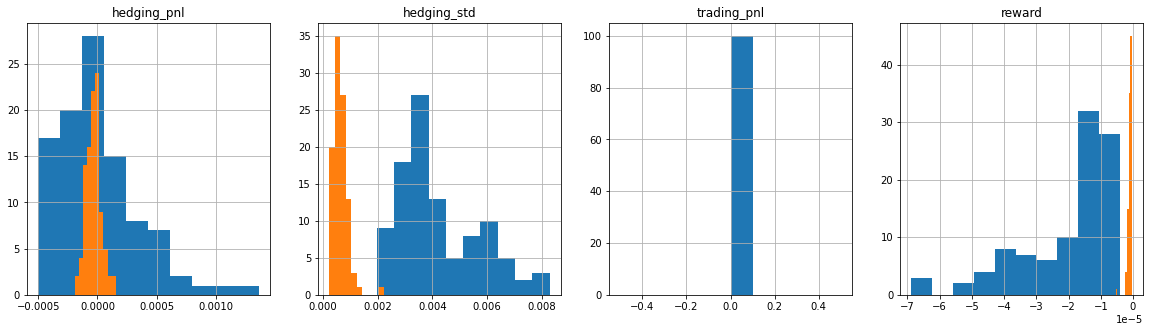

[2021-09-12 17:21:13,199] <WARNING>:default_logger:                
                You have not specified the i/o device of your model <class '__main__.QNet'>
                Automatically determined and set to: cpu

                The framework is not responsible for any un-matching device issues 
                caused by this operation.


processing episode 100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000027,0.003727,-0.000062,-0.000016,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000354,0.001403,0.000020,0.000011,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000591,0.001582,-0.000149,-0.000039,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000099,0.003371,-0.000061,-0.000012,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.001391,0.006235,-0.000044,-0.000003,0.000154,0.002232,-0.000103,-3.429219e-07


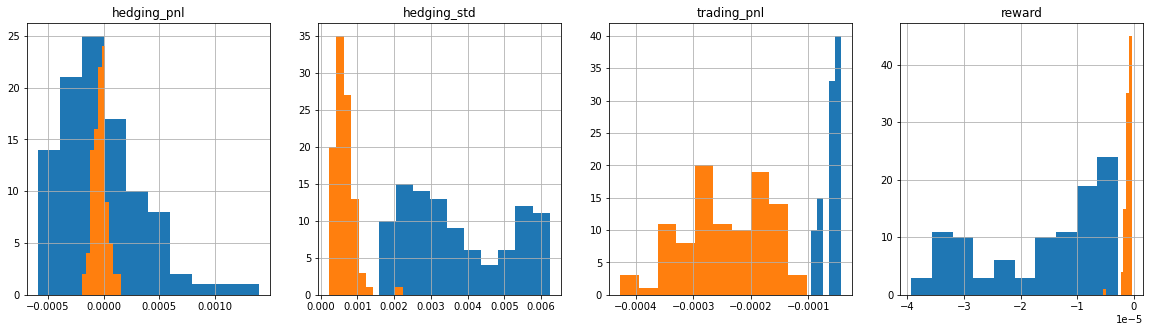

processing episode 200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000033,0.002682,-0.000134,-0.000008,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000238,0.000749,0.000090,0.000004,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000416,0.001149,-0.000393,-0.000019,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000068,0.002699,-0.000125,-0.000008,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000776,0.004385,-0.000026,-0.000002,0.000154,0.002232,-0.000103,-3.429219e-07


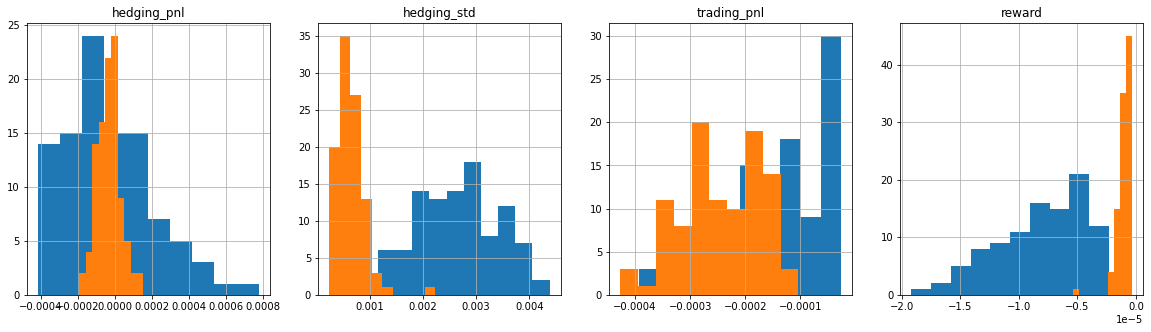

processing episode 300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001945,-0.000505,-0.000006,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000178,0.000337,0.000358,0.000002,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000338,0.001026,-0.001392,-0.000015,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000047,0.001924,-0.000428,-0.000005,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000506,0.003327,-0.000050,-0.000002,0.000154,0.002232,-0.000103,-3.429219e-07


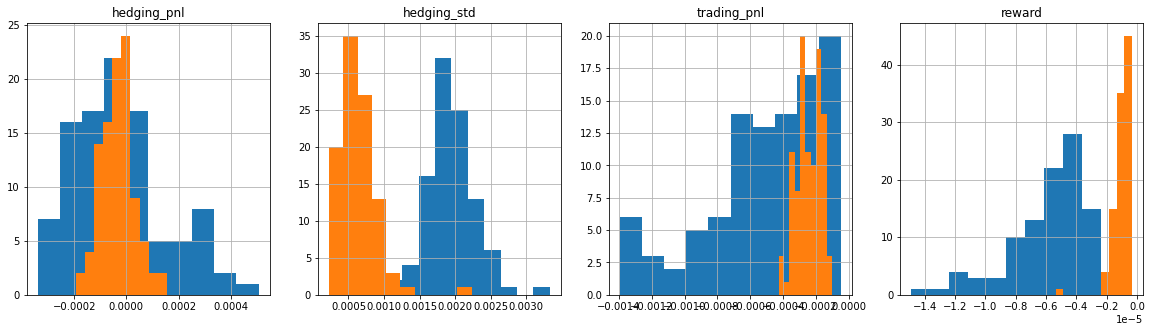

processing episode 400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000032,0.001689,-0.000227,-0.000004,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000147,0.000307,0.000115,0.000001,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000385,0.000949,-0.000617,-0.000008,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000041,0.001723,-0.000213,-0.000004,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000389,0.002725,-0.000050,-0.000001,0.000154,0.002232,-0.000103,-3.429219e-07


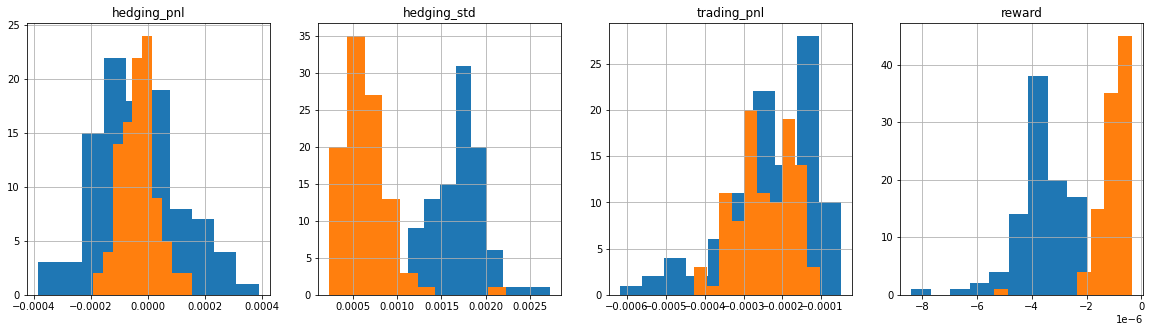

processing episode 500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001554,-0.000232,-0.000003,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000137,0.000341,0.000099,0.000001,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000390,0.000809,-0.000548,-0.000008,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000030,0.001523,-0.000201,-0.000003,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000422,0.002669,-0.000067,-0.000001,0.000154,0.002232,-0.000103,-3.429219e-07


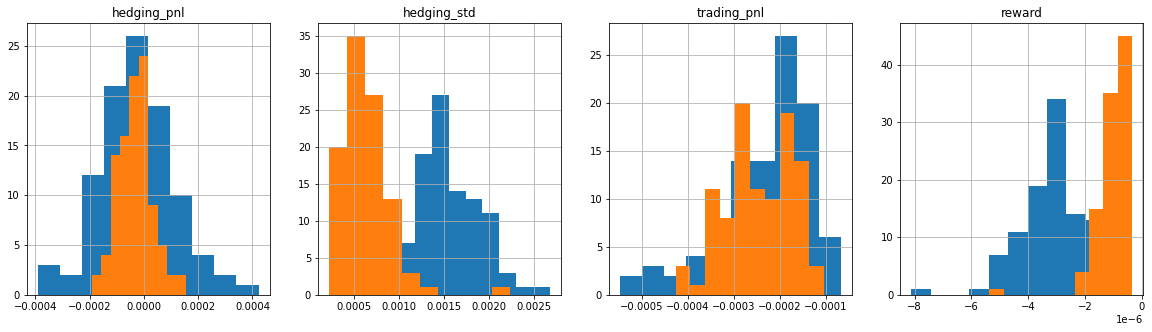

processing episode 600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000025,0.001549,-0.000194,-0.000003,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000145,0.000393,0.000084,0.000001,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000391,0.000782,-0.000408,-0.000008,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000040,0.001444,-0.000185,-0.000003,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000441,0.002539,-0.000055,-0.000001,0.000154,0.002232,-0.000103,-3.429219e-07


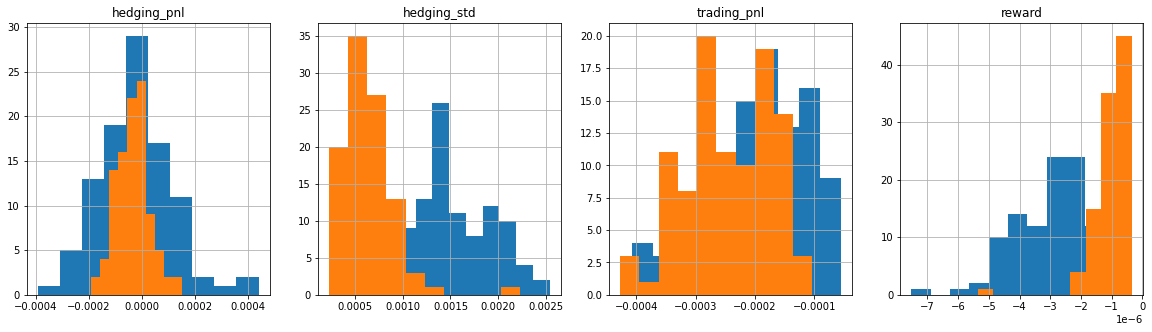

processing episode 700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000025,0.001465,-0.000194,-2.772708e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000132,0.000343,0.000078,9.481212e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000368,0.000735,-0.000419,-7.569392e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000029,0.001442,-0.000186,-2.645214e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000393,0.002541,-0.000055,-1.220858e-06,0.000154,0.002232,-0.000103,-3.429219e-07


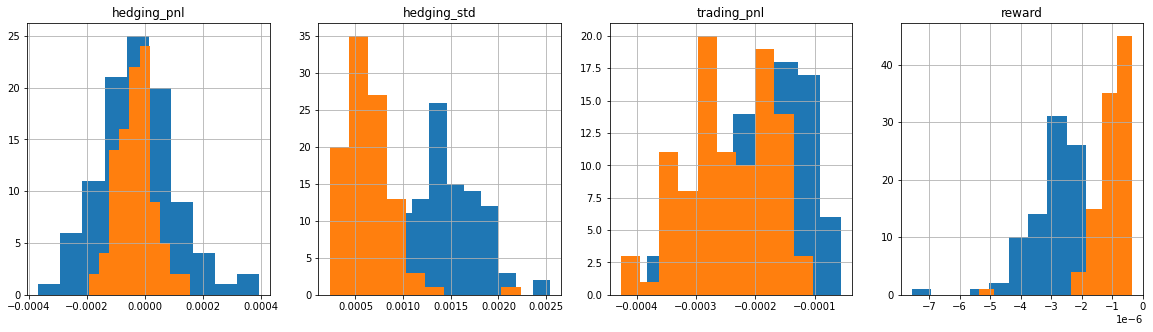

processing episode 800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000017,0.001566,-0.000198,-0.000003,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000135,0.000446,0.000078,0.000001,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000284,0.000750,-0.000454,-0.000007,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000031,0.001511,-0.000188,-0.000003,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000443,0.002573,-0.000070,-0.000001,0.000154,0.002232,-0.000103,-3.429219e-07


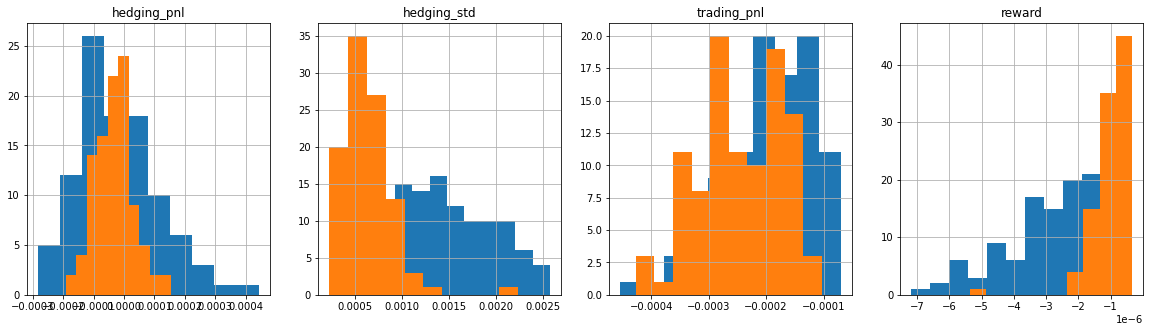

processing episode 900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000020,0.001261,-0.000221,-2.291354e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000121,0.000256,0.000085,7.114141e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000279,0.000734,-0.000530,-7.136225e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000021,0.001219,-0.000217,-2.152832e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000293,0.002567,-0.000061,-1.463724e-06,0.000154,0.002232,-0.000103,-3.429219e-07


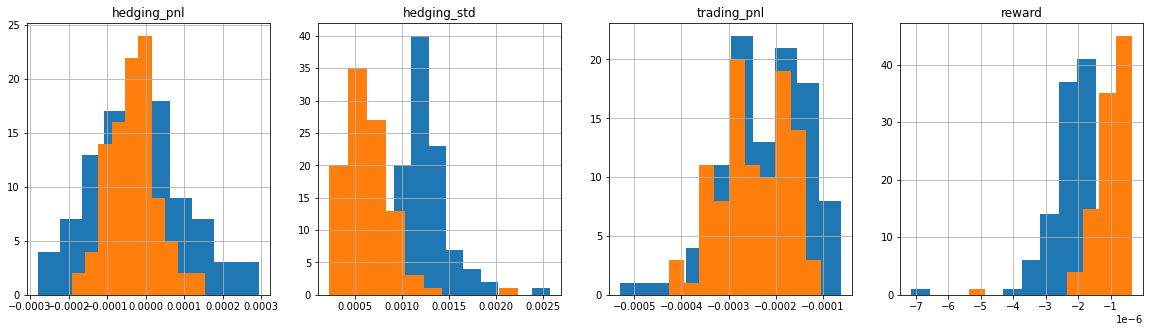

processing episode 1000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000027,0.001160,-0.000207,-2.004332e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000107,0.000268,0.000077,7.473460e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000249,0.000693,-0.000443,-7.118713e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000036,0.001095,-0.000192,-1.881485e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000233,0.002553,-0.000061,-1.122373e-06,0.000154,0.002232,-0.000103,-3.429219e-07


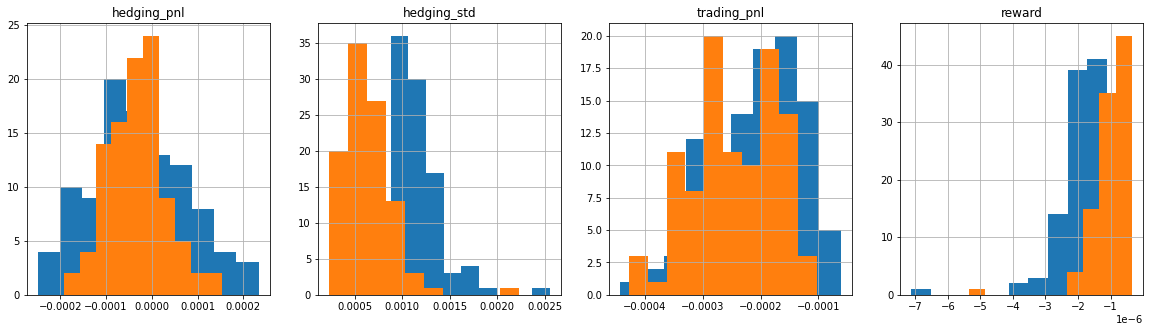

processing episode 1100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000027,0.001160,-0.000209,-1.920639e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000102,0.000266,0.000080,7.779049e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000243,0.000753,-0.000396,-7.083677e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000019,0.001085,-0.000204,-1.760286e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000305,0.002523,-0.000073,-9.832604e-07,0.000154,0.002232,-0.000103,-3.429219e-07


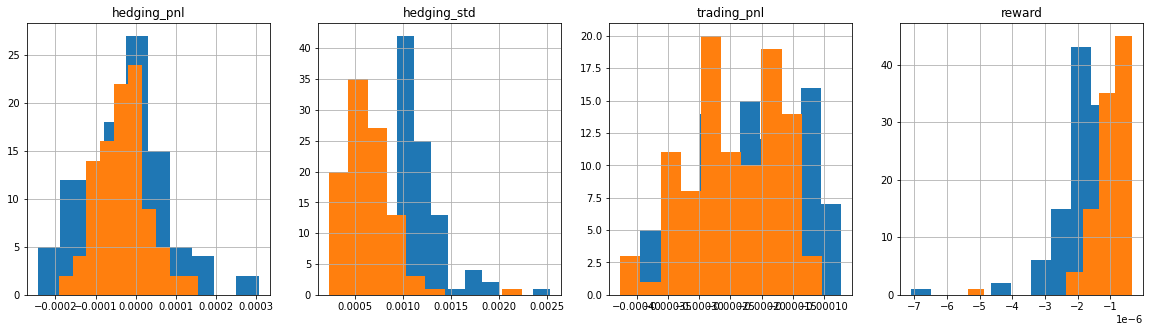

processing episode 1200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000028,0.001173,-0.000207,-1.953770e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000103,0.000262,0.000085,7.825110e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000214,0.000732,-0.000402,-7.451394e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000038,0.001114,-0.000204,-1.778450e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000284,0.002569,-0.000067,-1.002750e-06,0.000154,0.002232,-0.000103,-3.429219e-07


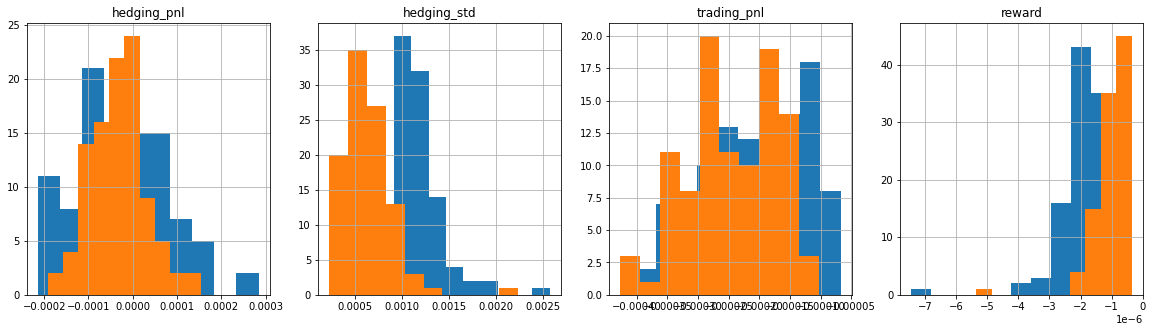

processing episode 1300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000029,0.001221,-0.000206,-2.176041e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000112,0.000280,0.000075,7.976518e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000293,0.000726,-0.000408,-7.194029e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000031,0.001159,-0.000202,-2.072610e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000243,0.002519,-0.000079,-1.254779e-06,0.000154,0.002232,-0.000103,-3.429219e-07


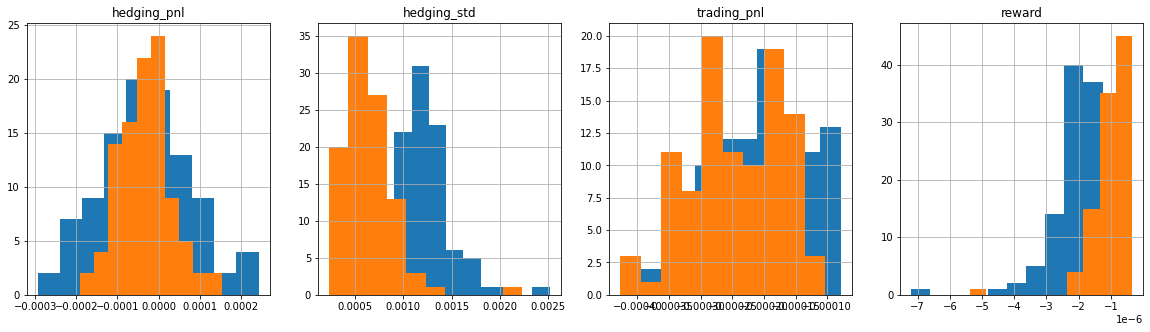

processing episode 1400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000032,0.001139,-0.000199,-1.948592e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000108,0.000263,0.000078,7.356667e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000253,0.000724,-0.000373,-7.023865e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000023,0.001094,-0.000191,-1.796644e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000230,0.002541,-0.000076,-1.061034e-06,0.000154,0.002232,-0.000103,-3.429219e-07


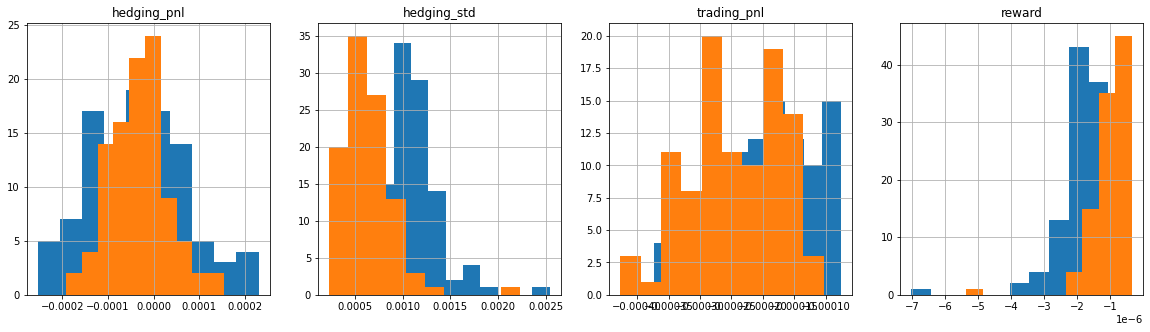

processing episode 1500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000033,0.001154,-0.000196,-2.012084e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000111,0.000263,0.000079,7.790546e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000276,0.000767,-0.000419,-7.607048e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000023,0.001081,-0.000188,-1.821700e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000247,0.002633,-0.000061,-1.205820e-06,0.000154,0.002232,-0.000103,-3.429219e-07


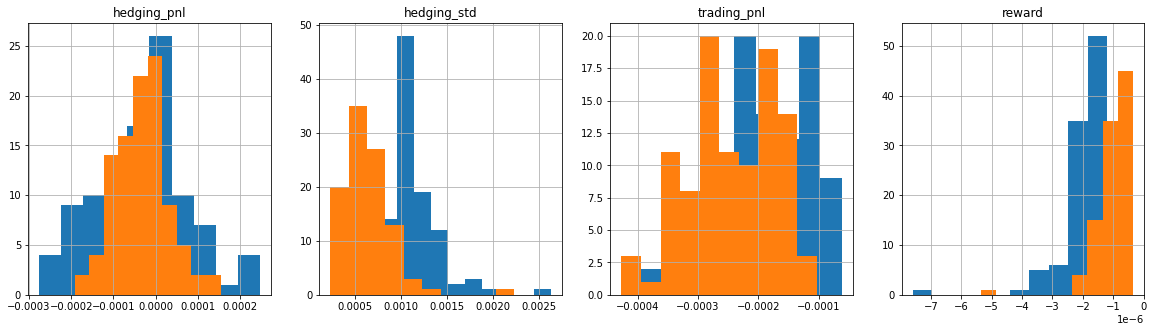

processing episode 1600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000029,0.001137,-0.000201,-1.944946e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000106,0.000266,0.000081,7.650340e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000249,0.000817,-0.000413,-7.069052e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000022,0.001076,-0.000188,-1.795321e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000235,0.002563,-0.000070,-1.105964e-06,0.000154,0.002232,-0.000103,-3.429219e-07


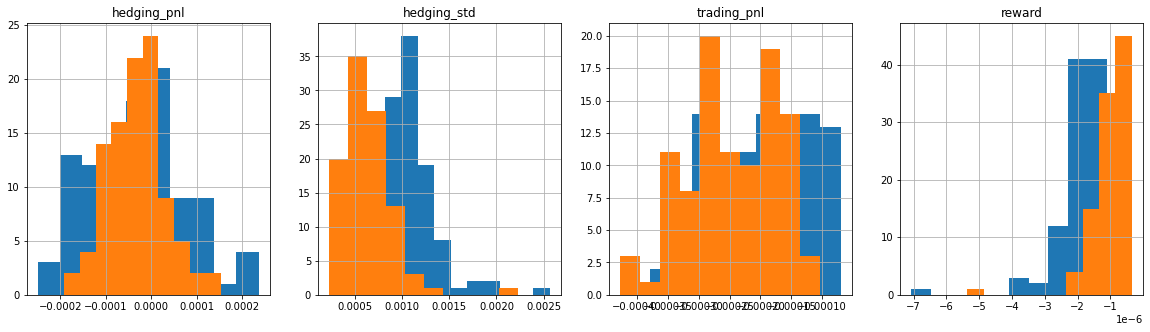

processing episode 1700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000026,0.001186,-0.000200,-2.035424e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000107,0.000283,0.000086,8.109243e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000251,0.000781,-0.000419,-7.128478e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000036,0.001136,-0.000189,-1.824074e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000298,0.002540,-0.000055,-1.121452e-06,0.000154,0.002232,-0.000103,-3.429219e-07


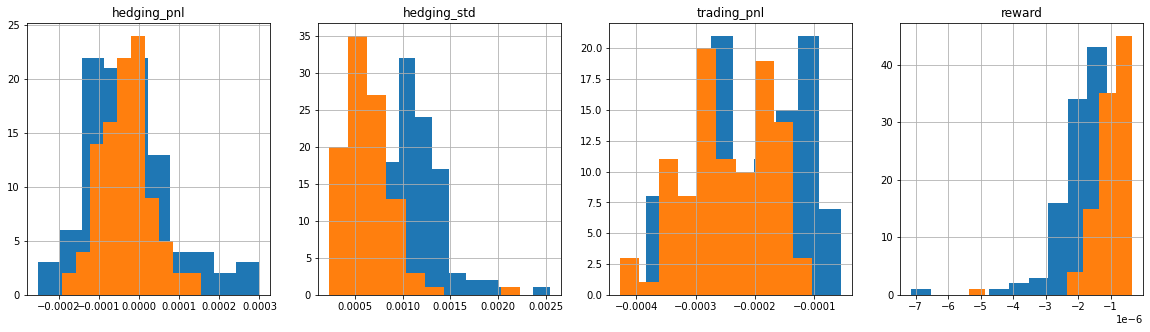

processing episode 1800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000022,0.001128,-0.000200,-1.865928e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000099,0.000272,0.000088,7.688498e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000264,0.000741,-0.000396,-7.031710e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000027,0.001072,-0.000182,-1.725896e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000271,0.002541,-0.000067,-9.485260e-07,0.000154,0.002232,-0.000103,-3.429219e-07


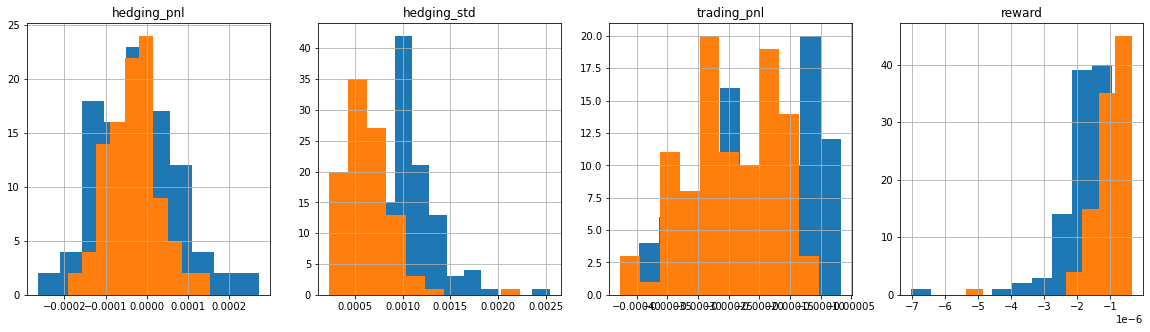

processing episode 1900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000029,0.001143,-0.000200,-1.924068e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000102,0.000261,0.000095,7.662438e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000228,0.000803,-0.000478,-7.158901e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.001086,-0.000183,-1.748523e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000231,0.002547,-0.000055,-9.486662e-07,0.000154,0.002232,-0.000103,-3.429219e-07


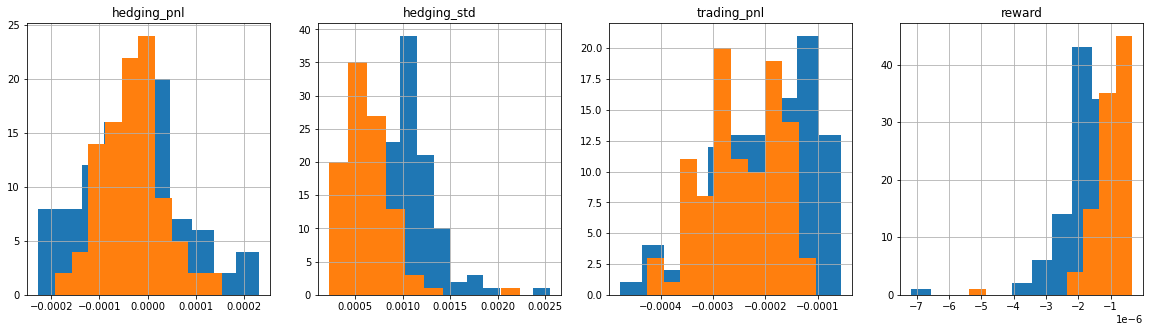

processing episode 2000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000026,0.001138,-0.000204,-1.915848e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000105,0.000265,0.000093,7.542199e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000236,0.000728,-0.000437,-6.949288e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000036,0.001102,-0.000186,-1.765434e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000259,0.002540,-0.000055,-1.002836e-06,0.000154,0.002232,-0.000103,-3.429219e-07


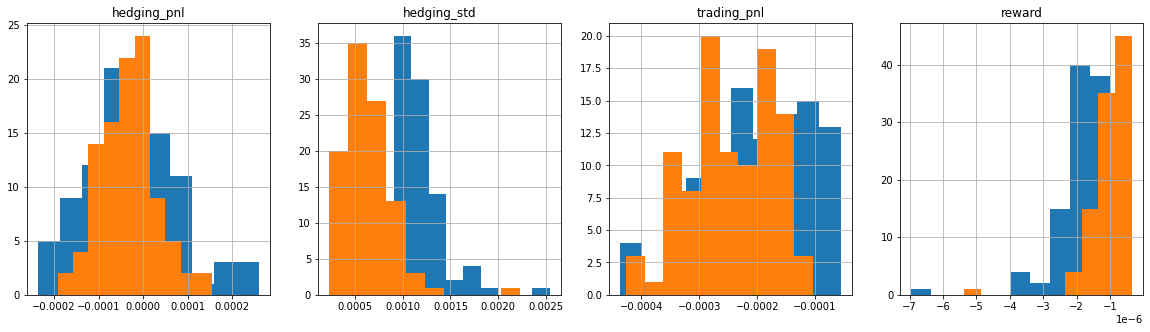

processing episode 2100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000026,0.001145,-0.000205,-1.972215e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000102,0.000285,0.000093,8.318409e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000250,0.000721,-0.000434,-7.159254e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.001059,-0.000192,-1.754476e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000236,0.002540,-0.000061,-1.055538e-06,0.000154,0.002232,-0.000103,-3.429219e-07


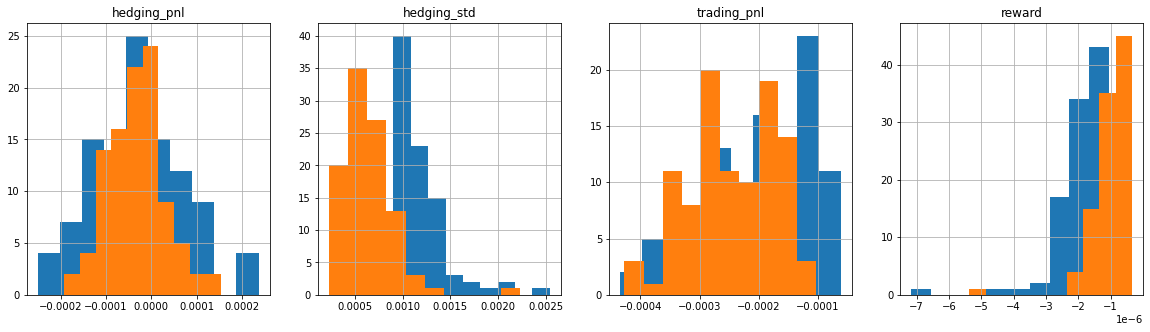

processing episode 2200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000028,0.001138,-0.000196,-1.904037e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000099,0.000272,0.000087,7.876879e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000222,0.000771,-0.000408,-6.768336e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000032,0.001073,-0.000186,-1.695230e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000245,0.002504,-0.000070,-9.589178e-07,0.000154,0.002232,-0.000103,-3.429219e-07


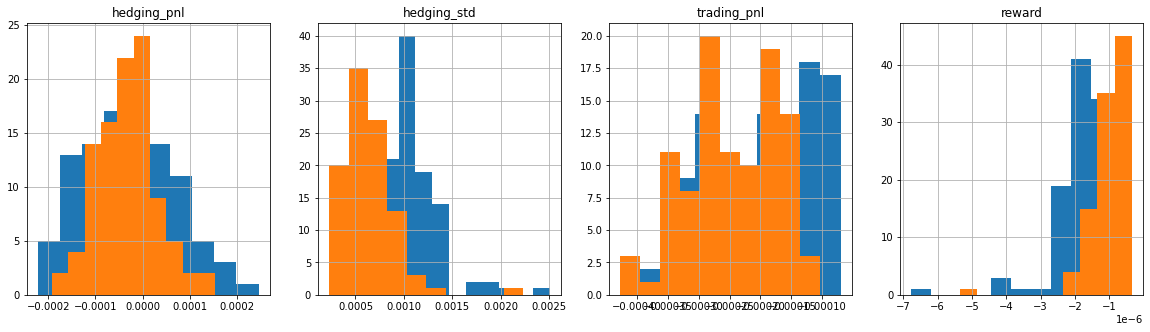

processing episode 2300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000031,0.001134,-0.000206,-1.922060e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000102,0.000265,0.000095,7.772354e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000268,0.000740,-0.000419,-7.123399e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000031,0.001078,-0.000198,-1.789252e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000210,0.002526,-0.000073,-9.924701e-07,0.000154,0.002232,-0.000103,-3.429219e-07


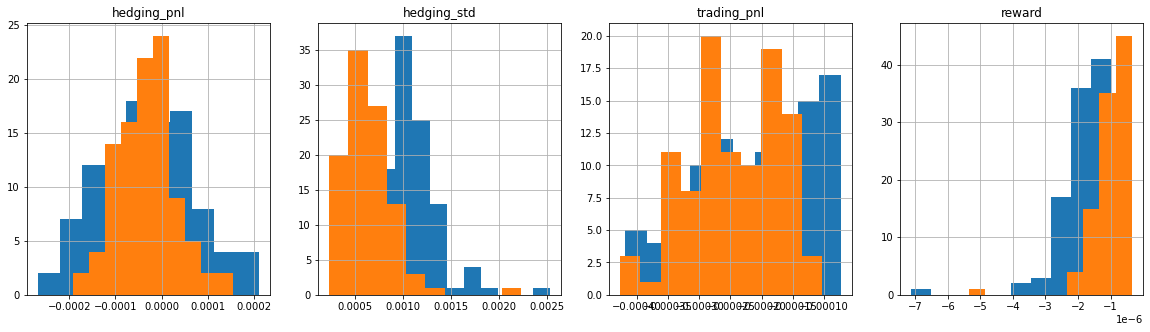

processing episode 2400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000030,0.001158,-0.000208,-1.979314e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000098,0.000257,0.000095,7.650037e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000240,0.000797,-0.000460,-7.085352e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000040,0.001109,-0.000202,-1.825243e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000224,0.002576,-0.000070,-1.012659e-06,0.000154,0.002232,-0.000103,-3.429219e-07


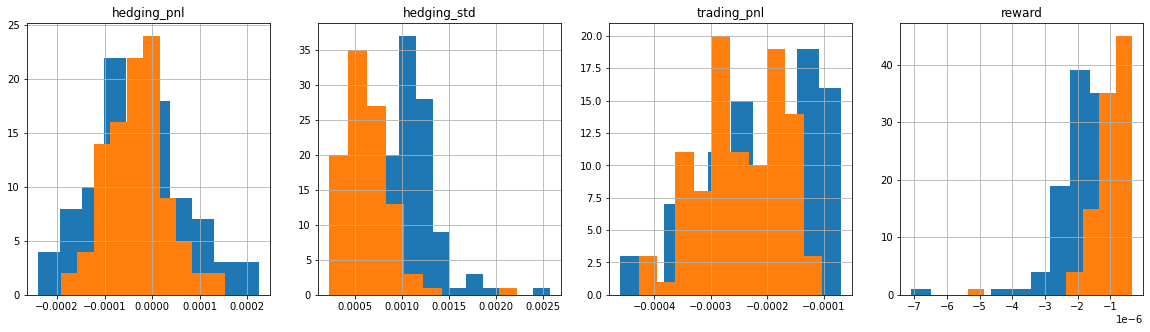

processing episode 2500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000023,0.001187,-0.000204,-2.042974e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000104,0.000266,0.000088,7.506430e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000205,0.000726,-0.000425,-6.504187e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000034,0.001125,-0.000184,-1.864321e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000289,0.002482,-0.000055,-1.028597e-06,0.000154,0.002232,-0.000103,-3.429219e-07


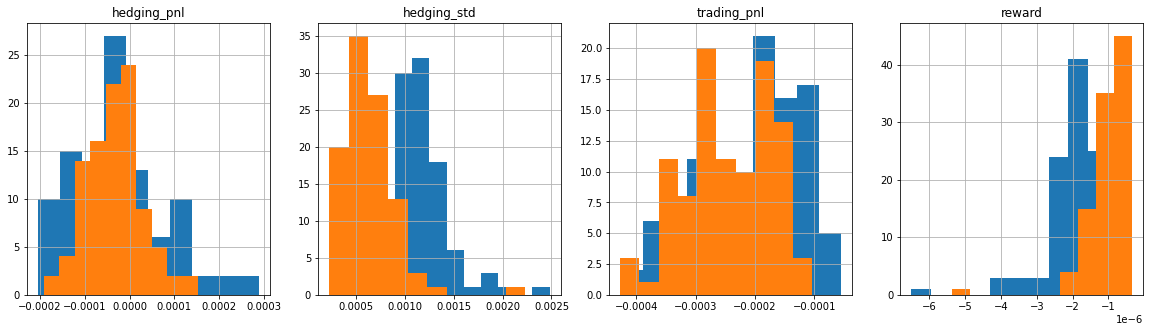

processing episode 2600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000031,0.001149,-0.000203,-1.959496e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000098,0.000274,0.000095,8.388412e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000249,0.000743,-0.000454,-7.799299e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.001091,-0.000189,-1.824332e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000229,0.002625,-0.000055,-9.124612e-07,0.000154,0.002232,-0.000103,-3.429219e-07


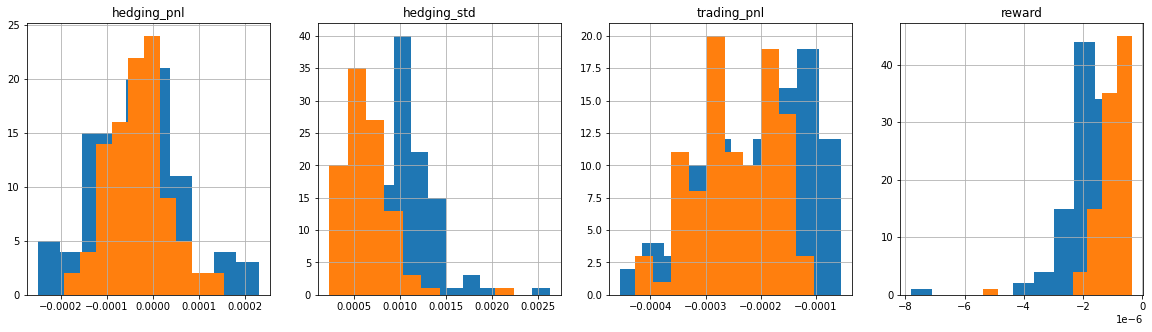

processing episode 2700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001064,-0.000216,-1.759608e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000097,0.000214,0.000085,6.199868e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000200,0.000690,-0.000413,-6.621399e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000019,0.001037,-0.000204,-1.632257e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000220,0.002499,-0.000079,-1.089862e-06,0.000154,0.002232,-0.000103,-3.429219e-07


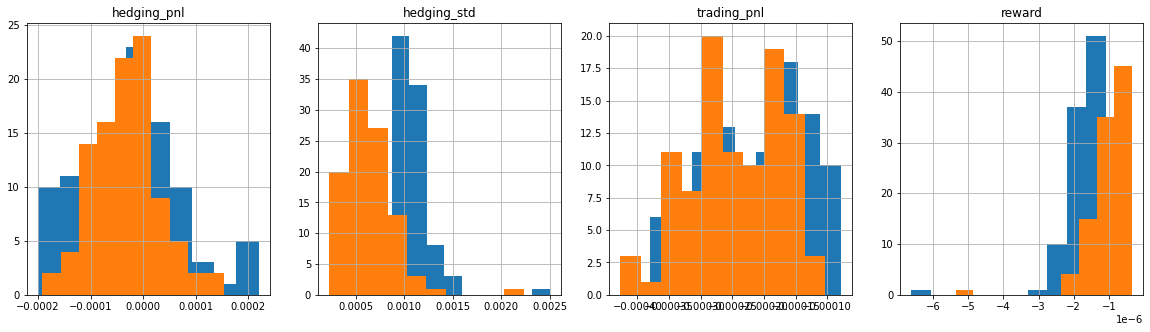

processing episode 2800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001018,-0.000212,-1.609830e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000092,0.000211,0.000088,6.294141e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000216,0.000656,-0.000419,-6.825016e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.001007,-0.000204,-1.458192e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000237,0.002483,-0.000079,-9.435477e-07,0.000154,0.002232,-0.000103,-3.429219e-07


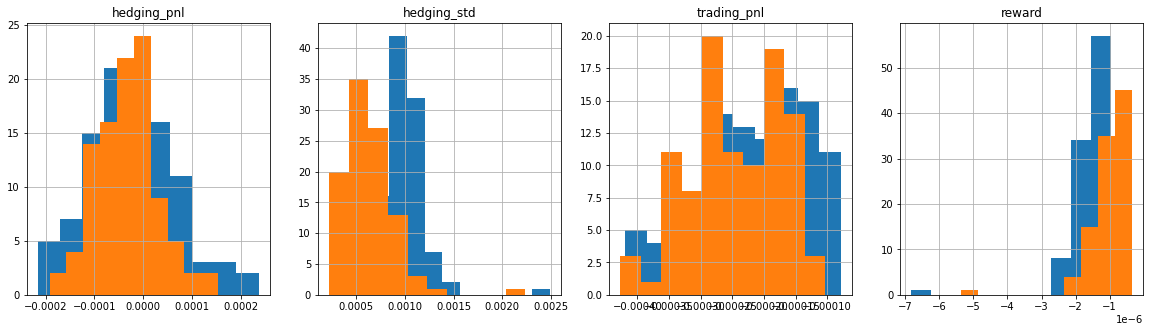

processing episode 2900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001054,-0.000220,-1.711688e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000094,0.000225,0.000092,6.865629e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000228,0.000734,-0.000431,-7.353719e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.001027,-0.000218,-1.597954e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000253,0.002645,-0.000079,-9.507940e-07,0.000154,0.002232,-0.000103,-3.429219e-07


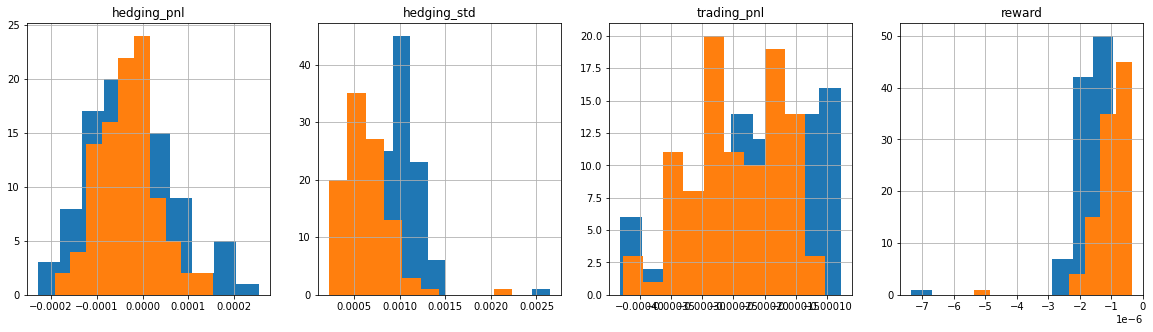

processing episode 3000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000021,0.001039,-0.000213,-1.691052e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000096,0.000232,0.000078,7.725076e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000221,0.000672,-0.000376,-8.477616e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000026,0.001029,-0.000207,-1.530602e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000223,0.002756,-0.000090,-9.970562e-07,0.000154,0.002232,-0.000103,-3.429219e-07


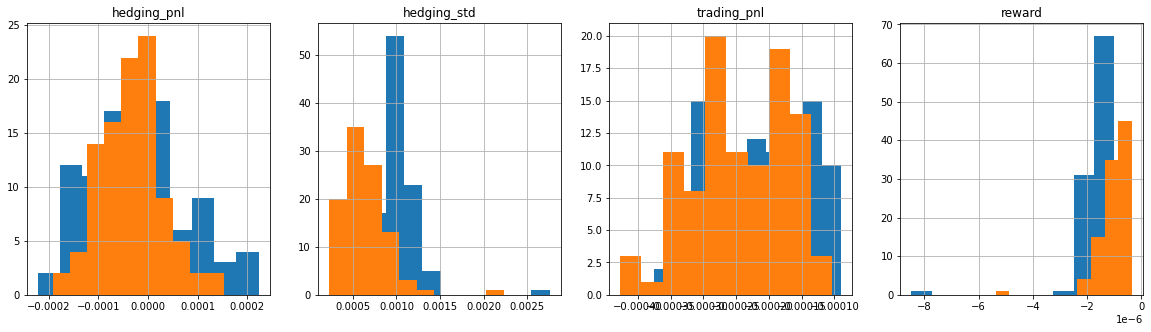

processing episode 3100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000021,0.001224,-0.000206,-2.133681e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000102,0.000247,0.000082,7.853995e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000257,0.000790,-0.000440,-7.476614e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000022,0.001189,-0.000189,-2.001133e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000287,0.002639,-0.000055,-1.107831e-06,0.000154,0.002232,-0.000103,-3.429219e-07


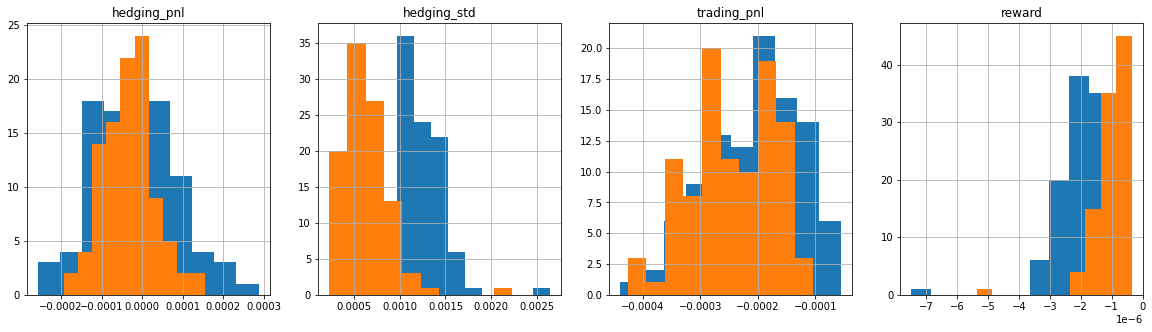

processing episode 3200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000029,0.001138,-0.000210,-2.012099e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000103,0.000268,0.000101,8.667899e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000267,0.000704,-0.000516,-6.498293e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000041,0.001089,-0.000188,-1.760159e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000258,0.002514,-0.000064,-1.009657e-06,0.000154,0.002232,-0.000103,-3.429219e-07


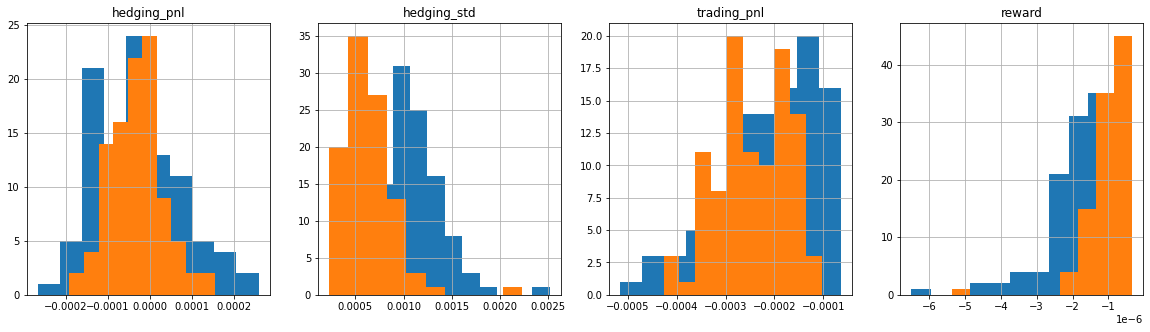

processing episode 3300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000028,0.001016,-0.000210,-1.658587e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000094,0.000221,0.000082,6.677487e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000214,0.000683,-0.000434,-7.196569e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.000995,-0.000201,-1.539254e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000222,0.002599,-0.000079,-9.648445e-07,0.000154,0.002232,-0.000103,-3.429219e-07


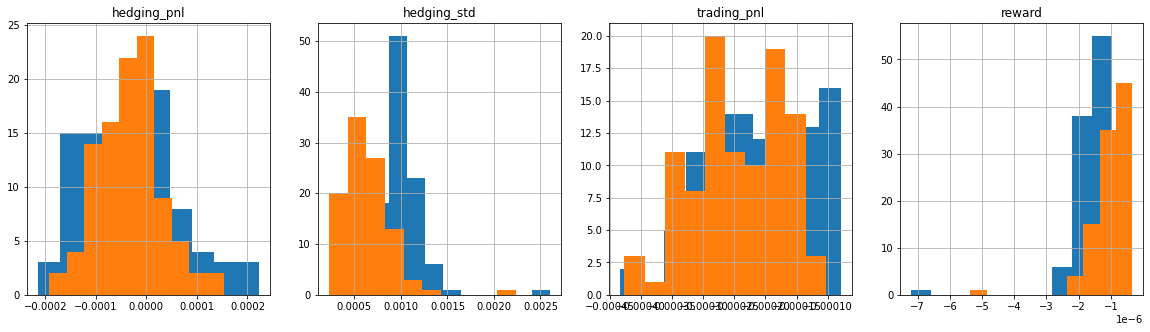

processing episode 3400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.001023,-0.000205,-1.619625e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000094,0.000224,0.000085,6.710873e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000225,0.000684,-0.000466,-7.147030e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000029,0.000996,-0.000195,-1.491147e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000247,0.002645,-0.000067,-8.249103e-07,0.000154,0.002232,-0.000103,-3.429219e-07


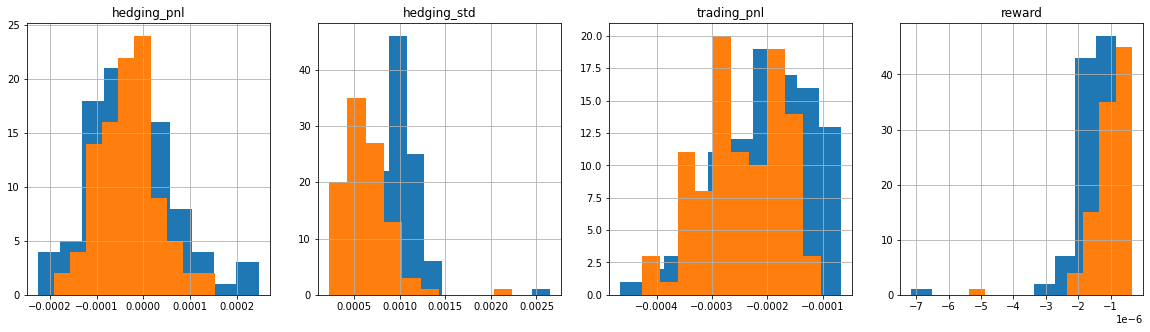

processing episode 3500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000026,0.000936,-0.000209,-1.478065e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000085,0.000250,0.000080,7.005459e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000202,0.000631,-0.000408,-6.687600e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000028,0.000908,-0.000198,-1.359477e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000242,0.002505,-0.000079,-7.184034e-07,0.000154,0.002232,-0.000103,-3.429219e-07


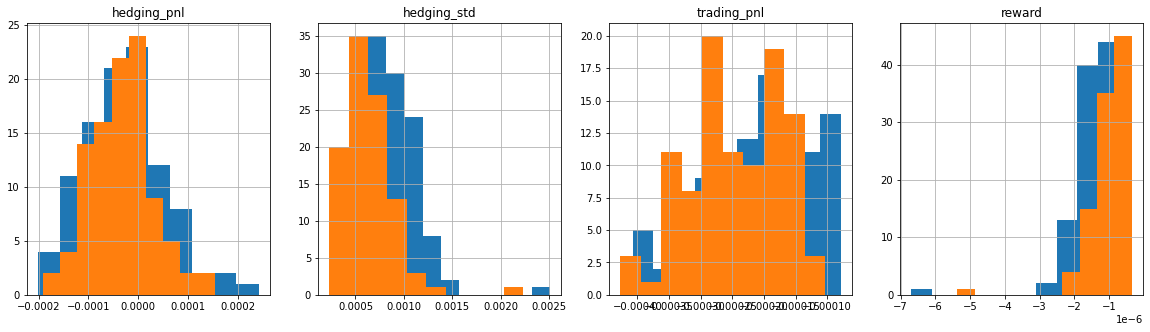

processing episode 3600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000031,0.000953,-0.000204,-1.523122e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000087,0.000252,0.000079,7.988061e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000205,0.000645,-0.000411,-8.329765e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000037,0.000909,-0.000191,-1.443311e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000231,0.002805,-0.000079,-7.564926e-07,0.000154,0.002232,-0.000103,-3.429219e-07


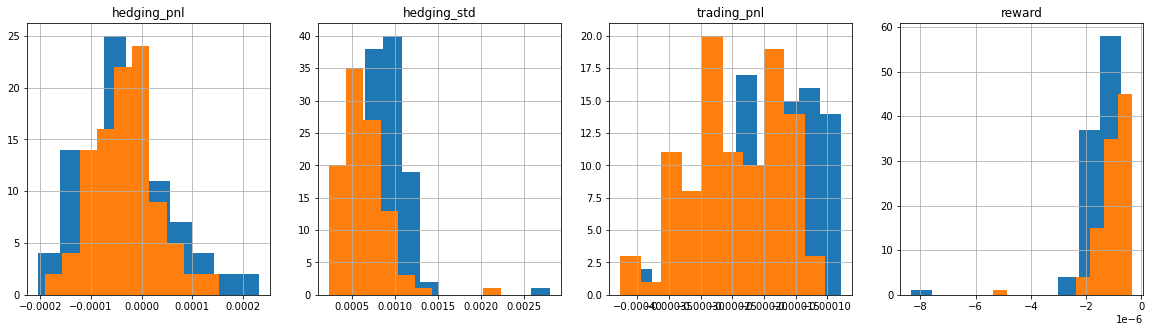

processing episode 3700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000021,0.001022,-0.000205,-1.600304e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000092,0.000195,0.000081,5.293253e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000197,0.000674,-0.000408,-5.363064e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000031,0.001006,-0.000195,-1.464997e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000233,0.002229,-0.000067,-8.919165e-07,0.000154,0.002232,-0.000103,-3.429219e-07


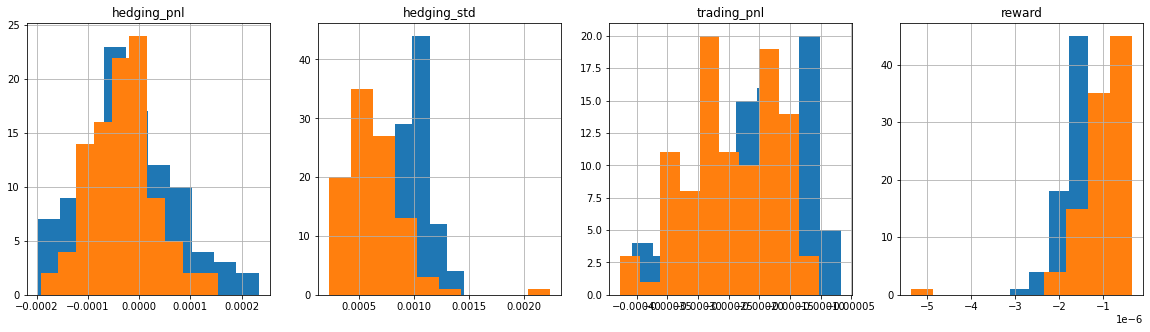

processing episode 3800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000028,0.000929,-0.000205,-1.480770e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000085,0.000247,0.000081,7.123109e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000194,0.000613,-0.000408,-7.220961e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000030,0.000890,-0.000195,-1.395445e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000207,0.002627,-0.000064,-6.935415e-07,0.000154,0.002232,-0.000103,-3.429219e-07


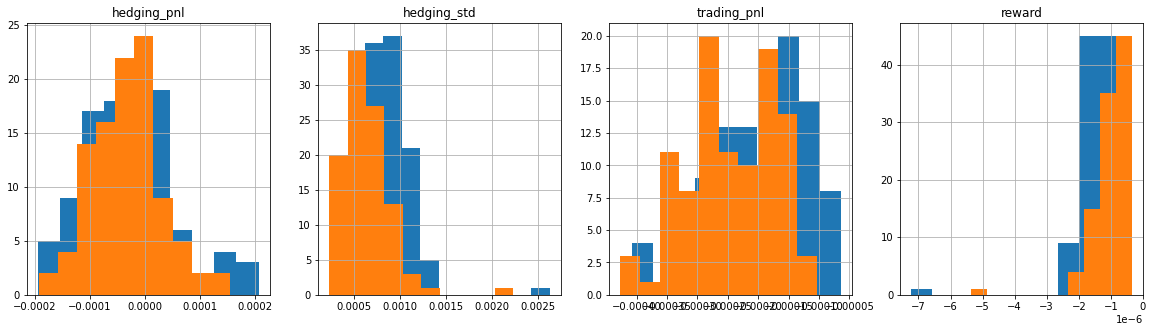

processing episode 3900


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000024,0.000968,-0.000203,-1.498716e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000088,0.000237,0.000080,6.629082e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000211,0.000593,-0.000411,-6.339129e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000032,0.000949,-0.000195,-1.416292e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000237,0.002494,-0.000064,-7.052504e-07,0.000154,0.002232,-0.000103,-3.429219e-07


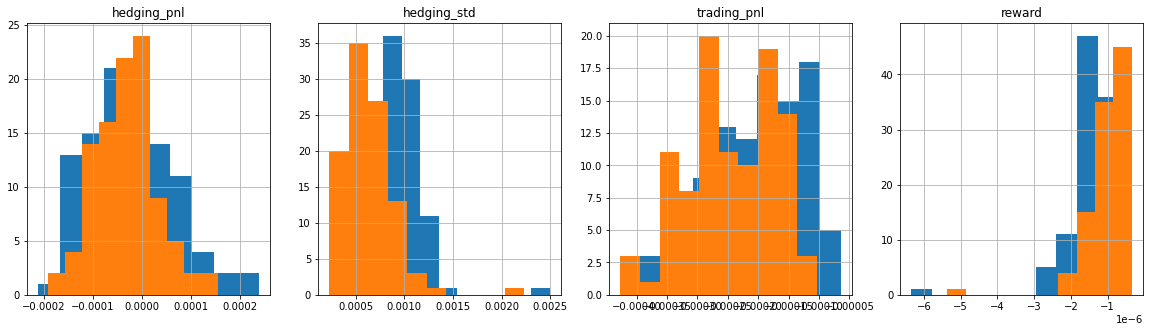

processing episode 4000


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000028,0.000914,-0.000208,-1.443991e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000084,0.000226,0.000079,6.215426e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000199,0.000606,-0.000443,-6.054965e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000034,0.000881,-0.000194,-1.371422e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000190,0.002409,-0.000076,-7.547889e-07,0.000154,0.002232,-0.000103,-3.429219e-07


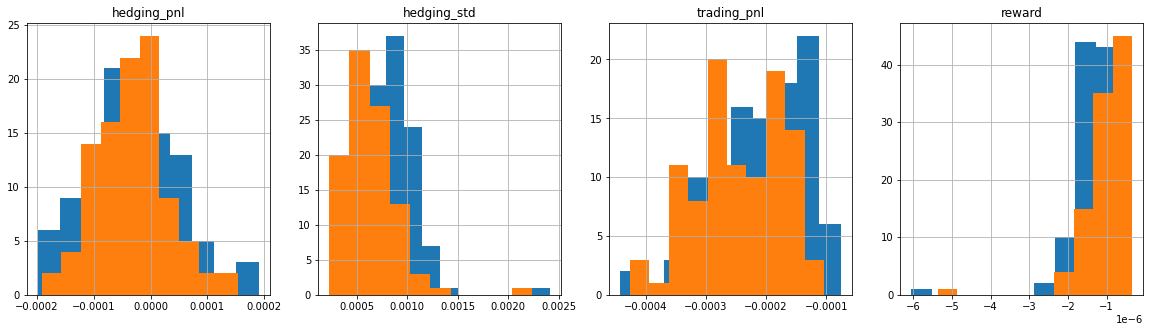

processing episode 4100


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000022,0.000896,-0.000204,-1.362403e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000084,0.000243,0.000077,6.319071e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000195,0.000541,-0.000425,-5.996424e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000021,0.000867,-0.000194,-1.270864e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000207,0.002433,-0.000082,-6.683300e-07,0.000154,0.002232,-0.000103,-3.429219e-07


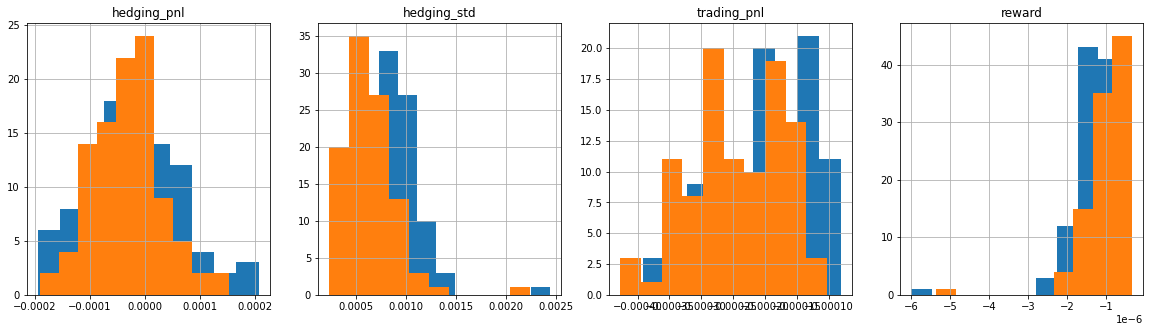

processing episode 4200


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000030,0.000947,-0.000204,-1.511953e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000086,0.000271,0.000078,8.142686e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000208,0.000635,-0.000425,-7.962643e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000037,0.000899,-0.000185,-1.407036e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000188,0.002778,-0.000087,-7.186409e-07,0.000154,0.002232,-0.000103,-3.429219e-07


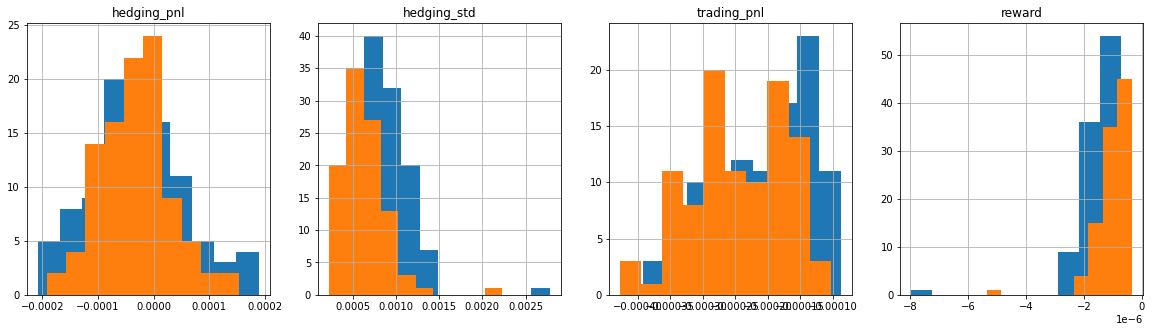

processing episode 4300


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000034,0.000878,-0.000210,-1.361635e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000082,0.000238,0.000077,6.885172e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000250,0.000610,-0.000422,-7.003712e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000044,0.000829,-0.000205,-1.263804e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000215,0.002576,-0.000076,-7.167666e-07,0.000154,0.002232,-0.000103,-3.429219e-07


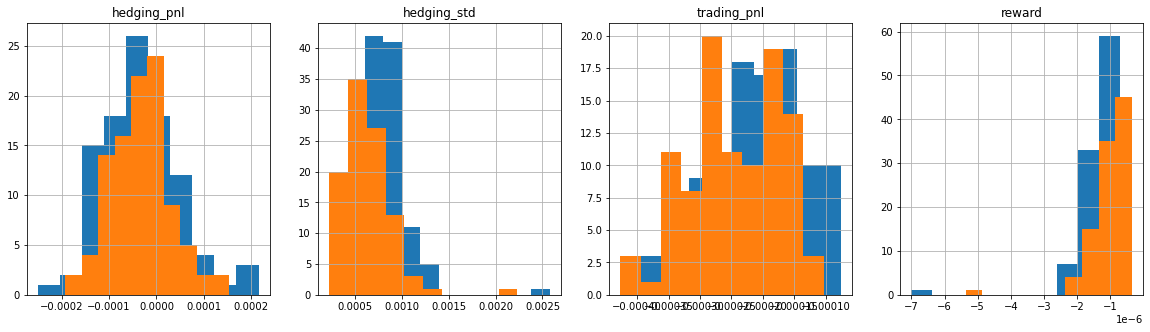

processing episode 4400


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000035,0.000921,-0.000208,-1.450513e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000086,0.000245,0.000078,6.949299e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000212,0.000591,-0.000451,-6.721062e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000041,0.000898,-0.000198,-1.336459e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000179,0.002559,-0.000070,-7.042865e-07,0.000154,0.002232,-0.000103,-3.429219e-07


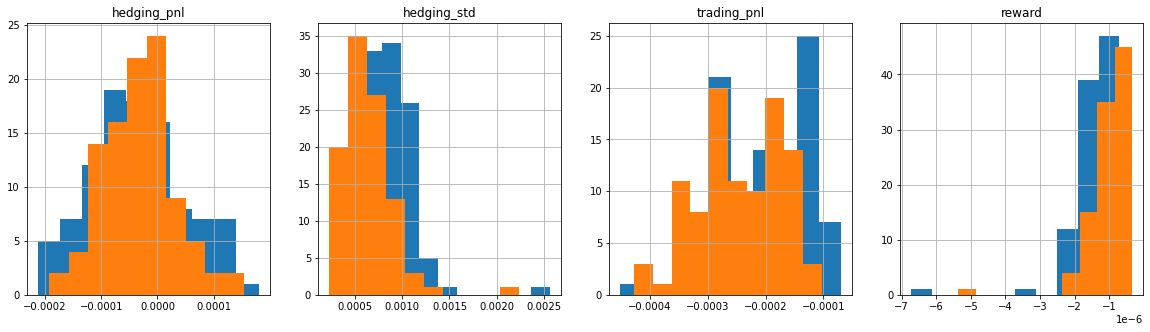

processing episode 4500


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000032,0.000916,-0.000199,-1.414919e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000088,0.000247,0.000075,7.621741e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000252,0.000553,-0.000422,-7.858057e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000034,0.000894,-0.000183,-1.251399e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000220,0.002760,-0.000070,-8.382027e-07,0.000154,0.002232,-0.000103,-3.429219e-07


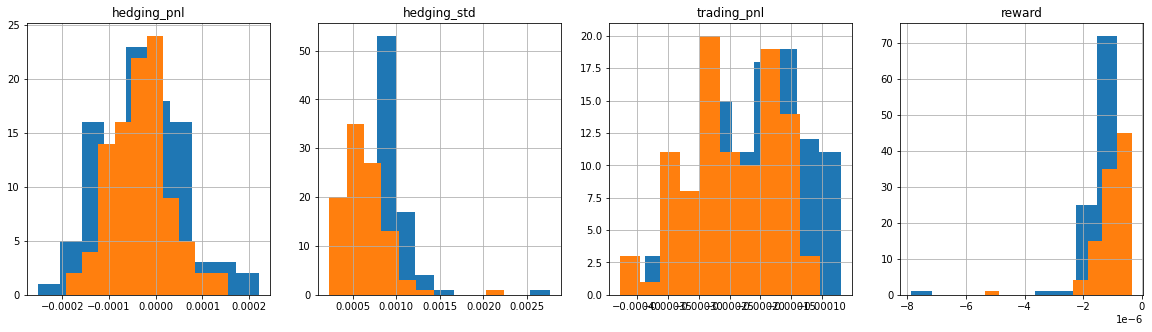

processing episode 4600


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000041,0.000865,-0.000211,-1.382047e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000073,0.000274,0.000077,7.350693e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000204,0.000461,-0.000402,-6.753763e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000042,0.000844,-0.000207,-1.307204e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000186,0.002495,-0.000064,-6.087732e-07,0.000154,0.002232,-0.000103,-3.429219e-07


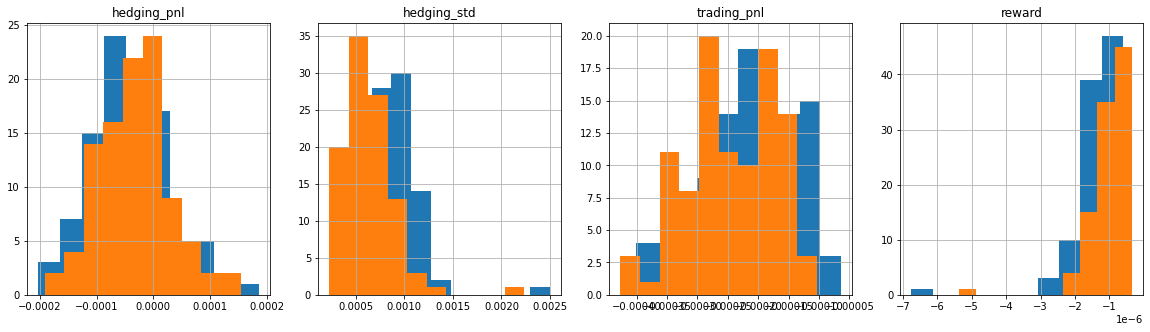

processing episode 4700


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000033,0.000931,-0.000215,-1.564568e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000087,0.000322,0.000082,1.176881e-06,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000220,0.000488,-0.000399,-1.195962e-05,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000043,0.000895,-0.000207,-1.416984e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000266,0.003364,-0.000073,-5.565539e-07,0.000154,0.002232,-0.000103,-3.429219e-07


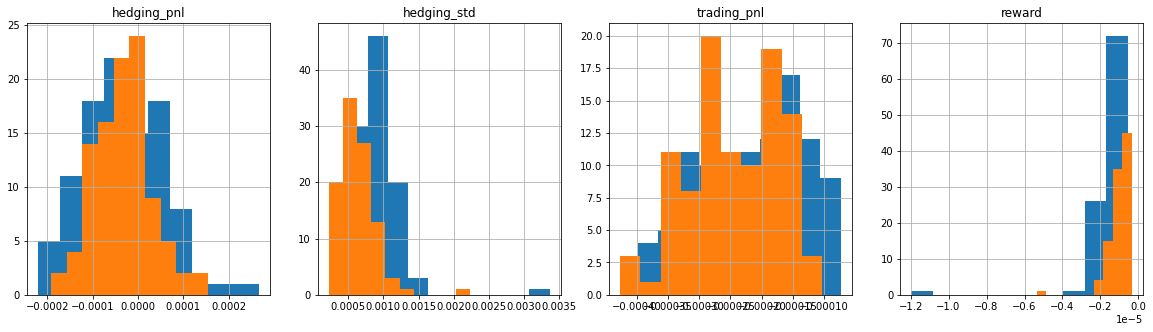

processing episode 4800


,hedging_pnl_rl,hedging_std_rl,trading_pnl_rl,reward_rl,hedging_pnl_delta,hedging_std_delta,trading_pnl_delta,reward_delta
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,-0.000035,0.000906,-0.000206,-1.401372e-06,-0.000031,0.000627,-0.000245,-1.004795e-06
std,0.000086,0.000254,0.000071,7.748952e-07,0.000062,0.000274,0.000073,6.174654e-07
min,-0.000223,0.000554,-0.000387,-7.995450e-06,-0.000192,0.000228,-0.000427,-5.363123e-06
50%,-0.000043,0.000891,-0.000207,-1.292257e-06,-0.000035,0.000587,-0.000247,-8.821563e-07
max,0.000244,0.002761,-0.000082,-6.930462e-07,0.000154,0.002232,-0.000103,-3.429219e-07


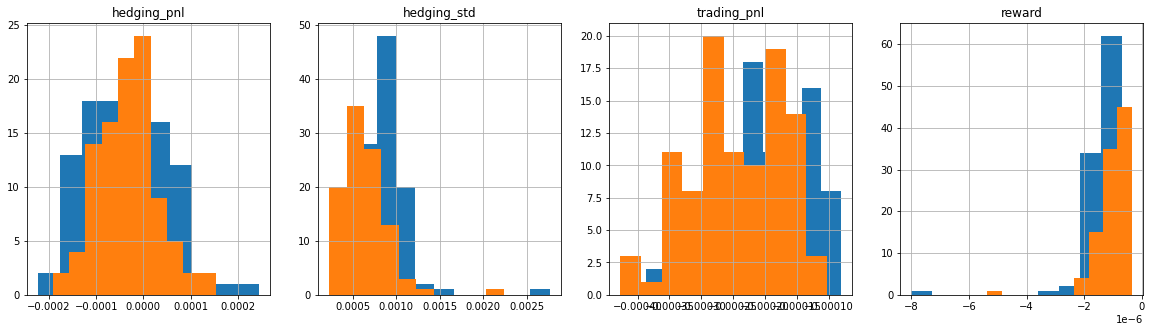

processing episode 4900


In [3]:
for j in range(num_eps):
    state = env.reset()
    done = False
    state = state[[0,1,2,4]]
    while not done:
        out = dqn.act_discrete_with_noise({"state": torch.tensor(state, dtype=torch.float32).unsqueeze(0)})
        action = out.squeeze().detach().numpy()/num_actions - env.h
        new_state, reward, done = env.step(action)
        reward = np.sum(reward)
        new_state = new_state[[0, 1, 2, 4]]
        reward = -norm_factor*((reward) ** 2 + 1 / 1000 * reward)

        dqn.store_episode([{
            "state": {"state": torch.tensor(state, dtype=torch.float32).unsqueeze(0)},
            "action": {"action": out},
            "next_state": {"state": torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)},
            "reward": float(reward),  # norm factor
            "terminal": done
        }])
        state = new_state

    if j % 100 == 0 and j != 0:
        rows = run_comparison(dqn, env)
        interpret_rows(rows)
        print(f"processing episode {j}")

    if j > 100:
        for _ in range(int(num_steps)):
            dqn.update()